## Introduction

This notebook is intended to prepare data regarding homelessness and housing factors. We want to look at this data in a way that will allow us to predict the rate of homeless individuals based on different factors (housing, demographic, geographic). 

The 2020 [point-in-time count](https://www.kingcounty.gov/elected/executive/constantine/news/release/2020/July/01-homeless-count.aspx) of people experiencing homelessness for Seattle/King County was 11,751. This represents a 5% increase over the 2019 count and reflects similar trend across many counties in the western U.S.. A step towards addressing homelessness is improving our understanding of the relationship between local housing market factors and homelessness. 

The U.S. Department of Housing and Urban Development (HUD) produced a report in 2019 [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) that describes a model-based approach to understanding of the relationship between local housing market factors and homelessness. Our project is motivated by the goals of the HUD study:

"To continue progressing toward the goals of ending and preventing homelessness, we must further our knowledge of the basic community-level determinants of homelessness. The primary objectives of this study are to (1) identify market factors that have established effects on homelessness, (2) construct and evaluate empirical models of community-level homelessness.."

We will investigate whether there are alternative modeling approaches that outperform the models described in the HUD report.


## Import libraries

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno
from sklearn.preprocessing import RobustScaler

# Train-test splits
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

## The data

The [data](https://github.com/brian-fischer/DATA-3320/blob/main/homelessness/05b_analysis_file_update.csv) for this project are described in HUD's report [Market Predictors of Homelessness](https://www.huduser.gov/portal/sites/default/files/pdf/Market-Predictors-of-Homelessness.pdf) in the section titled DATA.

I will refer you to this section of the HUD report for a detailed description of the sources of the data and how they were processed.

The data dictionary [HUD TO3 - 05b Analysis File - Data Dictionary.csv](https://github.com/brian-fischer/DATA-3320/blob/main/homelessness/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv) contains descriptions of all variables in the data set.




## Load the data

In [111]:
df = pd.read_csv('https://raw.githubusercontent.com/brian-fischer/DATA-3320/main/homelessness/05b_analysis_file_update.csv')

In [112]:
dictionary = pd.read_csv('https://raw.githubusercontent.com/brian-fischer/DATA-3320/main/homelessness/HUD%20TO3%20-%2005b%20Analysis%20File%20-%20Data%20-%20Dictionary.csv')

## Explore the contents of the data set

What variable(s) do we want to predict?

What variables seem useful as predictors?

Are any predictor variables redundant?


In [113]:
df.head()

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,sub_high_cost_rent75,sub_high_cost_homeval75,sub_high_rent_share75,tight_high_cost_rental_mkt,sub_tight_high_cost_rent,sub_west_coast_all_urb,sub_west_census,major_city,suburban,rural
0,2010,AK-500,1113.0,118.0,1231.0,633.0,107.0,740.0,480.0,11.0,...,1,1,1,3,1,1,1,1,0,0
1,2011,AK-500,1082.0,141.0,1223.0,677.0,117.0,794.0,405.0,24.0,...,1,1,0,3,1,1,1,1,0,0
2,2012,AK-500,1097.0,50.0,1147.0,756.0,35.0,791.0,341.0,15.0,...,1,1,1,3,1,1,1,1,0,0
3,2013,AK-500,1070.0,52.0,1122.0,792.0,52.0,844.0,278.0,0.0,...,1,1,0,3,1,1,1,1,0,0
4,2014,AK-500,970.0,53.0,1023.0,688.0,48.0,736.0,282.0,5.0,...,1,1,1,3,1,1,1,1,0,0


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Columns: 332 entries, year to rural
dtypes: float64(257), int64(73), object(2)
memory usage: 7.6+ MB


This dataframe has over 300 columns, so we will need the data dictionary to make sense of the different columns and what they are depicting

In [115]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 332 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    year                              int64  
 1    cocnumber                         object 
 2    pit_tot_shelt_pit_hud             float64
 3    pit_tot_unshelt_pit_hud           float64
 4    pit_tot_hless_pit_hud             float64
 5    pit_ind_shelt_pit_hud             float64
 6    pit_ind_unshelt_pit_hud           float64
 7    pit_ind_hless_pit_hud             float64
 8    pit_perfam_shelt_pit_hud          float64
 9    pit_perfam_unshelt_pit_hud        float64
 10   pit_perfam_hless_pit_hud          float64
 11   pit_ind_chronic_hless_pit_hud     float64
 12   pit_perfam_chronic_hless_pit_hud  float64
 13   pit_vet_hless_pit_hud             float64
 14   econ_urb_urbanicity               int64  
 15   coctag                            int64  
 16   panelvar              

Below, we can see the contents of the dictionary which helps us make sense of the more complex column names by tellinng us what that variable is actually keeping track of

In [116]:
dictionary

,Associated Domain,Variable,Variable Label,Derived,Source or Root Variable,Table Name(s)
0,Identifier,year,year,No,NaN,NaN
1,Identifier,cocnumber,continuum of care number,No,HUD,NaN
2,Outcome,pit_tot_shelt_pit_hud,total sheltered - HUD PIT,No,HUD PIT,NaN
3,Outcome,pit_tot_unshelt_pit_hud,total unsheltered - HUD PIT,No,HUD PIT,NaN
4,Outcome,pit_tot_hless_pit_hud,total homeless - HUD PIT,No,HUD PIT,NaN
...,...,...,...,...,...,...
327,Subgroup,sub_west_coast_all_urb,indicator for suburban or major city/largely u...,No,NaN,NaN
328,Subgroup,sub_west_census,indicator for west region CoCs,No,NaN,NaN
329,Subgroup,major_city,indicator for major city or largely urban CoC,No,HUD,NaN
330,Subgroup,suburban,indicator for largely suburban CoC,No,HUD,NaN


### Explore the data sources

Use the dictionary to find the unique `Associated Domain` values.


Make a bar graph of the counts of different data sources described in `Source or Root Variable`. Your graph should have the following features:

1. Order the bars in descending order based on the count.
2. Only include the 10 most common data sources.
3. Orient the plot so that it is easy to read the labels.


Use the dictionary to find the unique `Associated Domain` values.

In [117]:
dictionary['Associated Domain'].unique()

array(['Identifier', 'Outcome', 'Secondary Outcome', 'Subgroup',
       'Safety Net', 'Demographic', 'Housing', 'Economic', 'Local Policy',
       'Climate', 'Geography'], dtype=object)

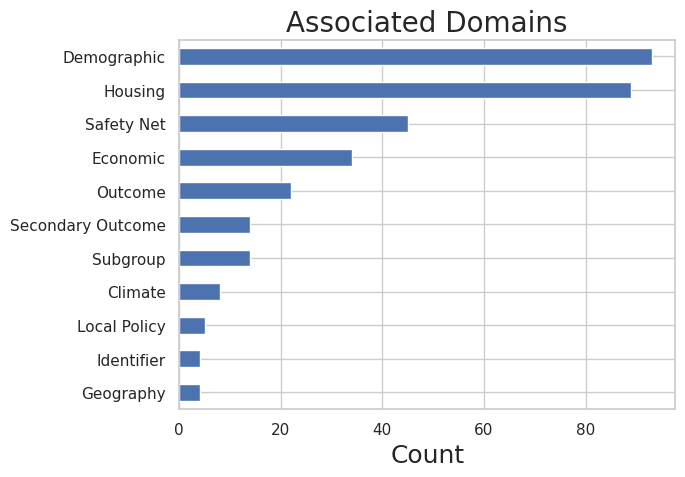

In [118]:
dictionary['Associated Domain'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()

plt.xlabel('Count', fontsize=18)
plt.title('Associated Domains', fontsize=20);

We can see most of the domains are demographic and housing domains

Make a bar graph of the counts of different data sources described in `Source or Root Variable`. Your graph should have the following features:

1. Order the bars in descending order based on the count.
2. Only include the 10 most common data sources.
3. Orient the plot so that it is easy to read the labels.

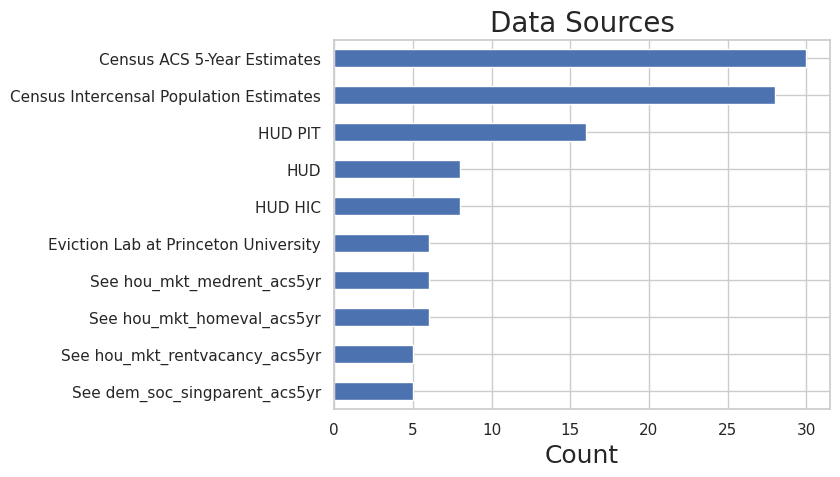

In [119]:
dictionary['Source or Root Variable'].value_counts().head(10).plot(kind='barh')
plt.gca().invert_yaxis()

plt.xlabel('Count', fontsize=18)
plt.title('Data Sources', fontsize=20);

Here we can see that most of the data sources come from the Census estimates

## Convert data types, if necessary

It does not appear necessary to convert data types.

## Select relevant subsets of the data

We have lots of different columns in our original dataframe, and not all of them are necessary. Here we scale down the total number of columns we wish to keep in order for our future analysis. 

In [120]:
columns_to_keep = ["year", "cocnumber",
  
                  "pit_tot_hless_pit_hud", "pit_tot_shelt_pit_hud", "pit_tot_unshelt_pit_hud","dem_pop_pop_census",
  
                  "fhfa_hpi_2009", "ln_hou_mkt_medrent_xt", "hou_mkt_utility_xt", "hou_mkt_burden_own_acs5yr_2017", "hou_mkt_burden_sev_rent_acs_2017", "hou_mkt_rentshare_acs5yr_2017", "hou_mkt_rentvacancy_xt", "hou_mkt_density_dummy", "hou_mkt_evict_count", "hou_mkt_ovrcrowd_acs5yr_2017", "major_city", "suburban",
           
                  "econ_labor_unemp_rate_BLS", "econ_labor_incineq_acs5yr_2017", "econ_labor_pov_pop_census_share",
           
                  "hou_pol_hudunit_psh_hud_share", "hou_pol_occhudunit_psh_hud", "hou_mkt_homeage1940_xt",
           
                  "dem_soc_black_census", "dem_soc_hispanic_census", "dem_soc_asian_census", "dem_soc_pacific_census", "dem_pop_child_census", "dem_pop_senior_census", "dem_pop_female_census", "dem_pop_mig_census", "d_dem_pop_mig_census_share", "dem_soc_singadult_xt", "dem_soc_singparent_xt", "dem_soc_vet_xt", "dem_soc_ed_lessbach_xt", "dem_health_cost_dart", "dem_health_excesdrink_chr",
           
                  "env_wea_avgtemp_noaa", "env_wea_avgtemp_summer_noaa", "env_wea_precip_noaa", "env_wea_precip_annual_noaa", "hou_mkt_homeage_xt", "dem_health_ins_xt",
                   
                   "econ_labor_pov_pop_census"]
    

In [121]:
df = df[columns_to_keep]

In [122]:
df.head()

,year,cocnumber,pit_tot_hless_pit_hud,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,dem_pop_pop_census,fhfa_hpi_2009,ln_hou_mkt_medrent_xt,hou_mkt_utility_xt,hou_mkt_burden_own_acs5yr_2017,...,dem_soc_ed_lessbach_xt,dem_health_cost_dart,dem_health_excesdrink_chr,env_wea_avgtemp_noaa,env_wea_avgtemp_summer_noaa,env_wea_precip_noaa,env_wea_precip_annual_noaa,hou_mkt_homeage_xt,dem_health_ins_xt,econ_labor_pov_pop_census
0,2010,AK-500,1231.0,1113.0,118.0,285194,0.000000,NaN,NaN,15.334315,...,NaN,7.78885,NaN,18.400000,56.599998,0.68,12.560000,NaN,NaN,21109
1,2011,AK-500,1223.0,1082.0,141.0,293370,0.009359,2.266958,9.3,15.334315,...,66.952057,7.85001,NaN,18.799999,55.799999,0.52,15.560000,1980.0,NaN,27351
2,2012,AK-500,1147.0,1097.0,50.0,296291,-0.049137,NaN,NaN,15.334315,...,NaN,7.90594,NaN,2.900000,55.900002,1.17,16.459999,NaN,NaN,24409
3,2013,AK-500,1122.0,1070.0,52.0,298520,-0.255042,2.266958,9.3,15.334315,...,66.952057,7.83198,NaN,23.299999,56.000000,1.10,20.270000,1980.0,NaN,26220
4,2014,AK-500,1023.0,970.0,53.0,301081,3.170481,NaN,NaN,15.334315,...,NaN,7.95718,NaN,30.299999,60.099998,1.52,24.010000,NaN,NaN,22753


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008 entries, 0 to 3007
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              3008 non-null   int64  
 1   cocnumber                         3008 non-null   object 
 2   pit_tot_hless_pit_hud             2994 non-null   float64
 3   pit_tot_shelt_pit_hud             2994 non-null   float64
 4   pit_tot_unshelt_pit_hud           2994 non-null   float64
 5   dem_pop_pop_census                3008 non-null   int64  
 6   fhfa_hpi_2009                     3008 non-null   float64
 7   ln_hou_mkt_medrent_xt             1504 non-null   float64
 8   hou_mkt_utility_xt                1504 non-null   float64
 9   hou_mkt_burden_own_acs5yr_2017    3008 non-null   float64
 10  hou_mkt_burden_sev_rent_acs_2017  3008 non-null   float64
 11  hou_mkt_rentshare_acs5yr_2017     3008 non-null   float64
 12  hou_mk

Create the dictionary for the subset of columns.

In [124]:
dictionary_small = dictionary[dictionary['Variable'].isin(columns_to_keep)]

In [125]:
dictionary_small.head()

,Associated Domain,Variable,Variable Label,Derived,Source or Root Variable,Table Name(s)
0,Identifier,year,year,No,NaN,NaN
1,Identifier,cocnumber,continuum of care number,No,HUD,NaN
2,Outcome,pit_tot_shelt_pit_hud,total sheltered - HUD PIT,No,HUD PIT,NaN
3,Outcome,pit_tot_unshelt_pit_hud,total unsheltered - HUD PIT,No,HUD PIT,NaN
4,Outcome,pit_tot_hless_pit_hud,total homeless - HUD PIT,No,HUD PIT,NaN


We want our dictionary to match the columns that we have subset in our dataframe

How many variables of each Associated Domain are in the smaller data set?


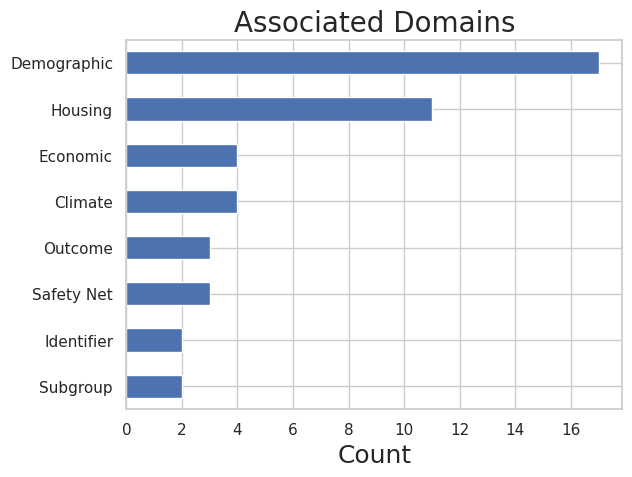

In [126]:
dictionary_small['Associated Domain'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis()

plt.xlabel('Count', fontsize=18)
plt.title('Associated Domains', fontsize=20);

Demographic and housing are still the top two associated domains, just with smaller counts

What are the data sources in the smaller data set?


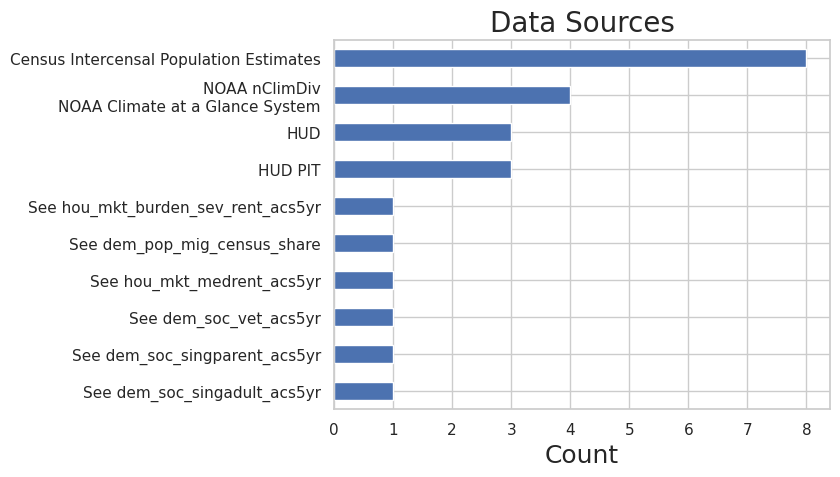

In [127]:
dictionary_small['Source or Root Variable'].value_counts().head(10).plot(kind='barh')
plt.gca().invert_yaxis()

plt.xlabel('Count', fontsize=18)
plt.title('Data Sources', fontsize=20);

One of the census sources is still one of the highest counts of data sources, but the NOAA climate data also has a high count of sources

## Are the data suitable for answering the question?

We want to perform quick exploratory data analysis to determine whether the data are sufficient to answer our question. If the data are not sufficient, we do not want to waste time doing anything that will not be productive.

In [128]:
df.columns


Index(['year', 'cocnumber', 'pit_tot_hless_pit_hud', 'pit_tot_shelt_pit_hud',
       'pit_tot_unshelt_pit_hud', 'dem_pop_pop_census', 'fhfa_hpi_2009',
       'ln_hou_mkt_medrent_xt', 'hou_mkt_utility_xt',
       'hou_mkt_burden_own_acs5yr_2017', 'hou_mkt_burden_sev_rent_acs_2017',
       'hou_mkt_rentshare_acs5yr_2017', 'hou_mkt_rentvacancy_xt',
       'hou_mkt_density_dummy', 'hou_mkt_evict_count',
       'hou_mkt_ovrcrowd_acs5yr_2017', 'major_city', 'suburban',
       'econ_labor_unemp_rate_BLS', 'econ_labor_incineq_acs5yr_2017',
       'econ_labor_pov_pop_census_share', 'hou_pol_hudunit_psh_hud_share',
       'hou_pol_occhudunit_psh_hud', 'hou_mkt_homeage1940_xt',
       'dem_soc_black_census', 'dem_soc_hispanic_census',
       'dem_soc_asian_census', 'dem_soc_pacific_census',
       'dem_pop_child_census', 'dem_pop_senior_census',
       'dem_pop_female_census', 'dem_pop_mig_census',
       'd_dem_pop_mig_census_share', 'dem_soc_singadult_xt',
       'dem_soc_singparent_xt', 'dem_s

<ipython-input-129-742161715af1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.dropna().corr(), vmin=-1, vmax=1)


<Axes: >

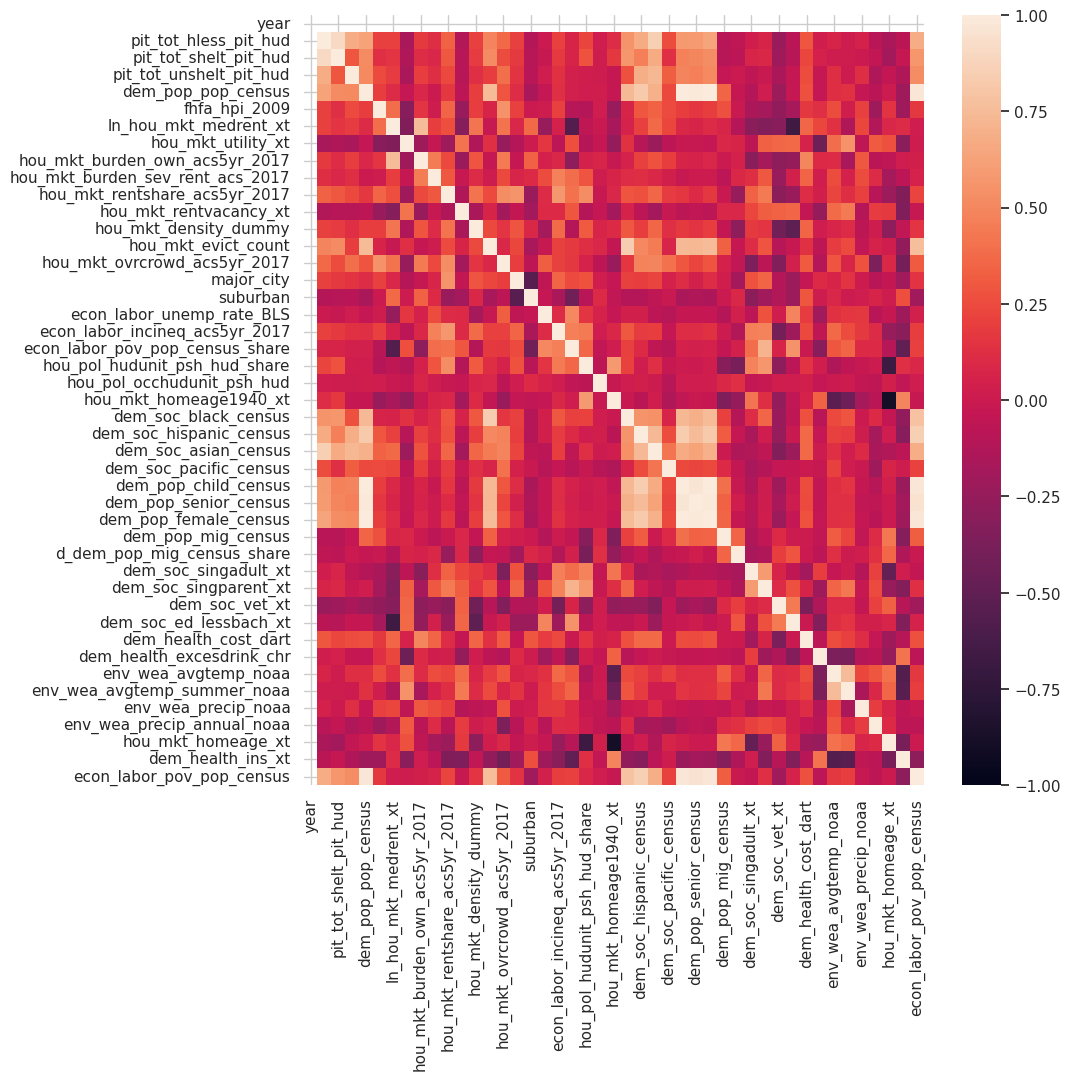

In [129]:
plt.figure(figsize=(10,10))
sns.heatmap(df.dropna().corr(), vmin=-1, vmax=1)

The data seems sufficient to answer the question. 

## Rename columns

In [130]:
df = df.rename(columns = {"cocnumber":"coc_number",
  
                          "pit_tot_hless_pit_hud":"total_homeless", 
                          "pit_tot_shelt_pit_hud":"total_sheltered", 
                          "pit_tot_unshelt_pit_hud":"total_unsheltered",
                          "dem_pop_pop_census":"total_population",
  
                          "fhfa_hpi_2009":"house_price_index_2009", 
                          "ln_hou_mkt_medrent_xt":"log_median_rent", 
                          "hou_mkt_utility_xt":"utility_costs", 
                          "hou_mkt_burden_own_acs5yr_2017":"percentage_owners_cost_burden_2016", 
                          "hou_mkt_burden_sev_rent_acs_2017":"percentage_renters_severe_cost_burden_2016", 
                          "hou_mkt_rentshare_acs5yr_2017":"share_renters_2016", 
                          "hou_mkt_rentvacancy_xt":"rental_vacancy_rate", 
                          "hou_mkt_density_dummy":"high_housing_density", 
                          "hou_mkt_evict_count":"number_eviction", 
                          "hou_mkt_ovrcrowd_acs5yr_2017":"share_overcrowded_units_2016", 
                          "major_city":"city_or_urban", 
           
                          "econ_labor_unemp_rate_BLS":"rate_unemployment", 
                          "econ_labor_incineq_acs5yr_2017":"gini_coefficient_2016", 
                          "econ_labor_pov_pop_census_share":"poverty_rate",
                          "econ_labor_pov_pop_census": "poverty_count",
           
                          "hou_pol_hudunit_psh_hud_share":"share_HUD_units", 
                          "hou_pol_occhudunit_psh_hud":"HUD_unit_occupancy_rate", 
                          "hou_mkt_homeage1940_xt":"share_built_before_1940",
                          "hou_mkt_homeage_xt": "median_housing_structure_age",
           
                          "dem_soc_black_census":"total_black", 
                          "dem_soc_hispanic_census":"total_latino_hispanic", 
                          "dem_soc_asian_census":"total_asian", 
                          "dem_soc_pacific_census":"total_pacific_islander", 
                          "dem_pop_child_census":"total_population_0_19", 
                          "dem_pop_senior_census":"total_population_65_plus", 
                          "dem_pop_female_census":"total_female_population", 
                          "dem_pop_mig_census":"net_migration", 
                          "d_dem_pop_mig_census_share":"migration_4_year_change", 
                          "dem_soc_singadult_xt":"proportion_one_person_households", 
                          "dem_soc_singparent_xt":"share_under_18_with_single_parent", 
                          "dem_soc_vet_xt":"share_veteran_status", 
                          "dem_soc_ed_lessbach_xt":"share_no_bachelors", 
                          "dem_health_cost_dart":"medicare_reimbursements_per_enrollee", 
                          "dem_health_excesdrink_chr":"percentage_excessive_drinking",
                          "dem_health_ins_xt": "population_health_insurance",
           
                          "env_wea_avgtemp_noaa":"average_Jan_temperature", 
                          "env_wea_avgtemp_summer_noaa":"average_summer_temperature", 
                          "env_wea_precip_noaa":"total_Jan_precipitation", 
                          "env_wea_precip_annual_noaa":"total_annual_precipitation"})

## Quality Control

We want to make sure all the data in our dataframe makes sense, and there aren't any bad observations or observations that will mess with our analysis later on

In [131]:
df.agg(['min','max']).T

,min,max
year,2010,2017
coc_number,AK-500,WY-500
total_homeless,7.0,76501.0
total_sheltered,3.0,72565.0
total_unsheltered,0.0,42828.0
total_population,29344,11058958
house_price_index_2009,-26.497087,63.864007
log_median_rent,1.239243,2.874838
utility_costs,5.6,22.6
percentage_owners_cost_burden_2016,8.072322,22.955448


## Identify and deal with missing values

Determine whether there are missing values in the data set. Determine whether you have missing values after focusing on the relevant subset of the data.

<Axes: >

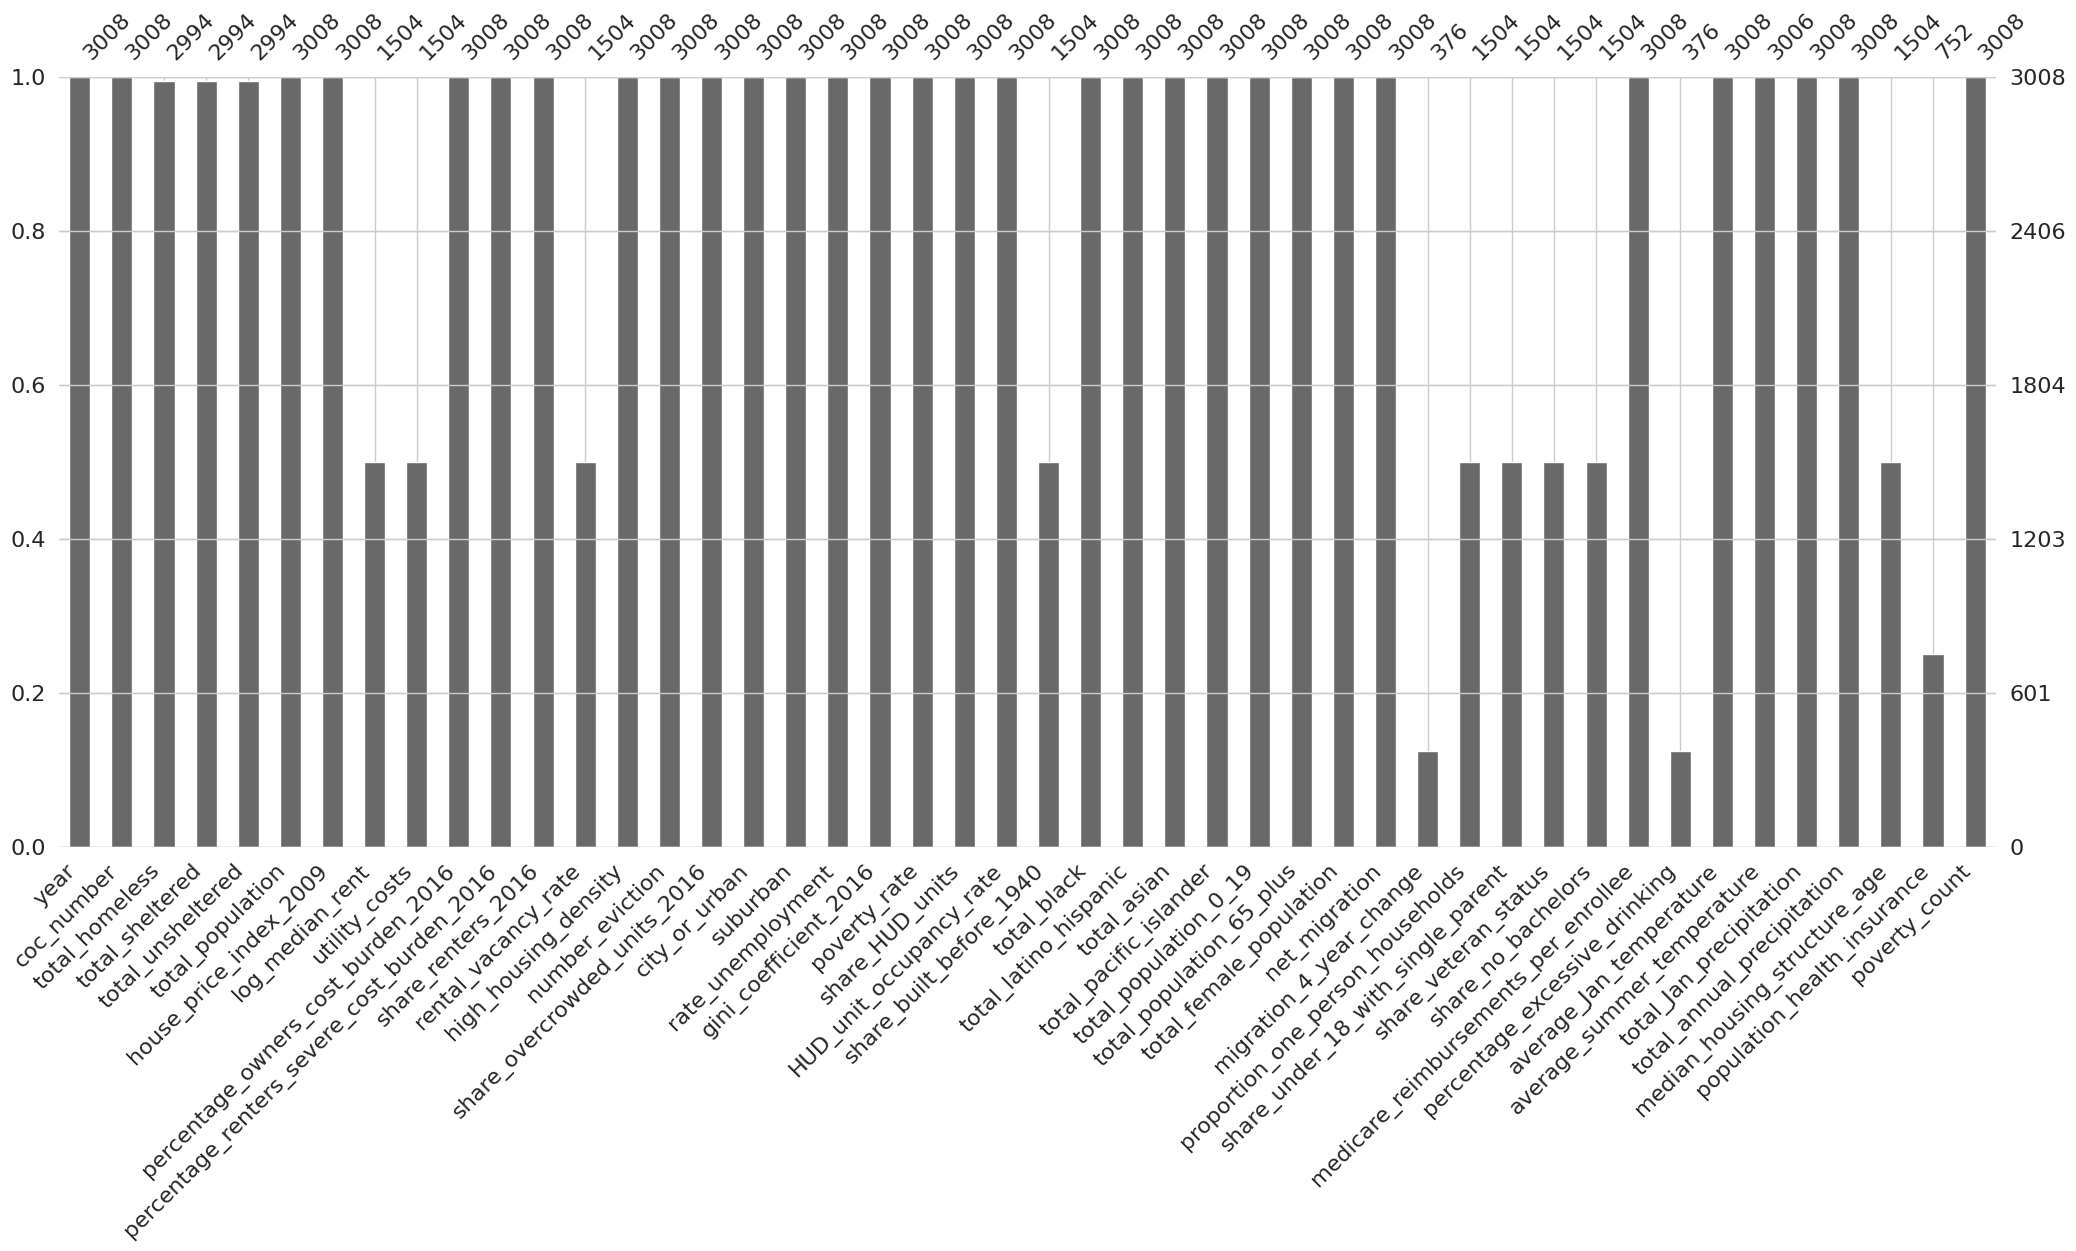

In [132]:
msno.bar(df)

<Axes: >

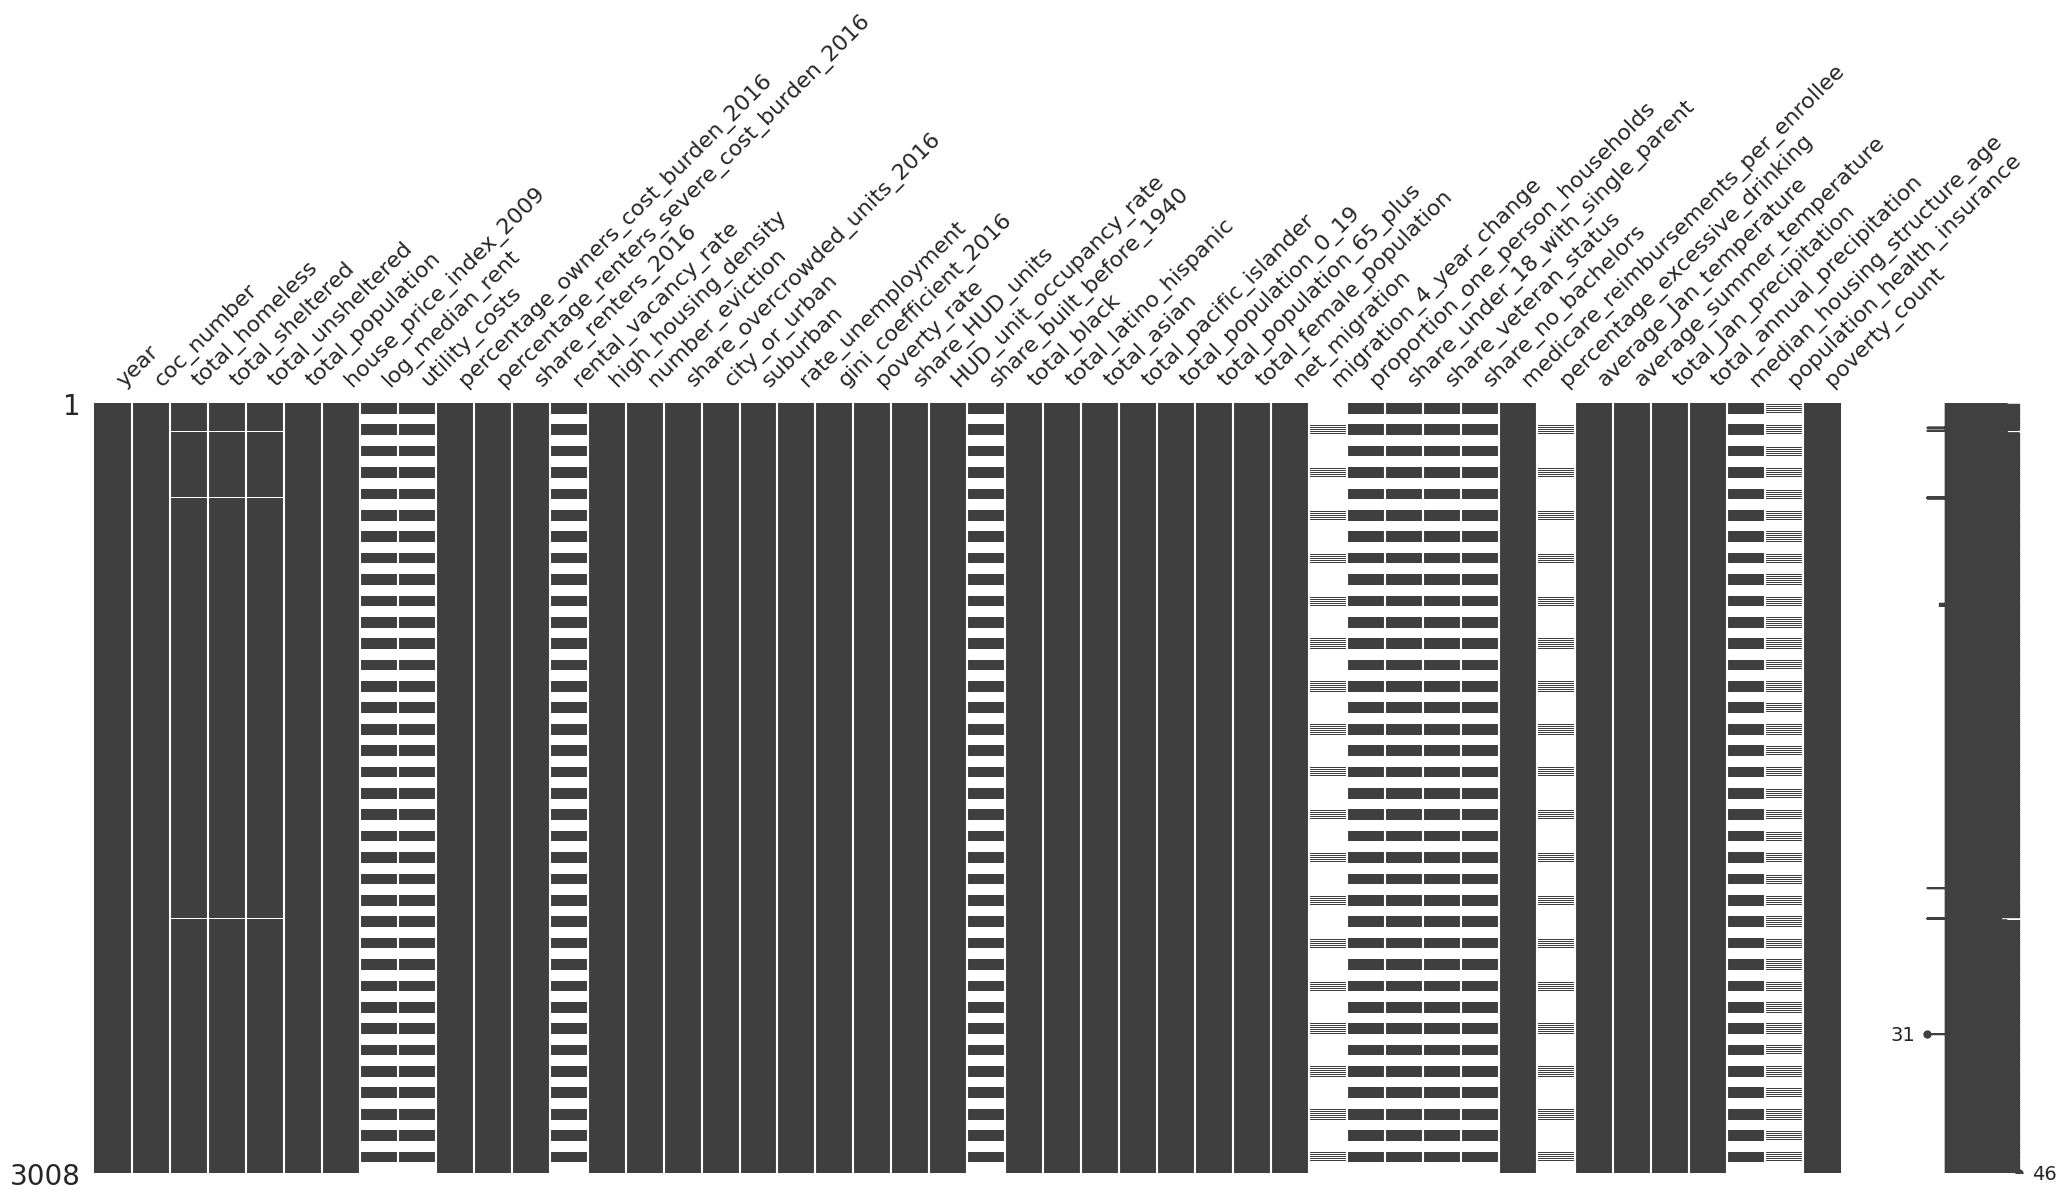

In [133]:
msno.matrix(df)

Get rid of rows where `total_homeless` is missing

In [134]:
df = df.loc[df['total_homeless'].notna()]

Keep only data from 2017

In [135]:
df = df.loc[df['year'] == 2017]

In [136]:
df.isna().sum()

year                                          0
coc_number                                    0
total_homeless                                0
total_sheltered                               0
total_unsheltered                             0
total_population                              0
house_price_index_2009                        0
log_median_rent                               0
utility_costs                                 0
percentage_owners_cost_burden_2016            0
percentage_renters_severe_cost_burden_2016    0
share_renters_2016                            0
rental_vacancy_rate                           0
high_housing_density                          0
number_eviction                               0
share_overcrowded_units_2016                  0
city_or_urban                                 0
suburban                                      0
rate_unemployment                             0
gini_coefficient_2016                         0
poverty_rate                            

In high danger of over fitting since we have so little observations and so many predictors

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 7 to 3007
Data columns (total 46 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        374 non-null    int64  
 1   coc_number                                  374 non-null    object 
 2   total_homeless                              374 non-null    float64
 3   total_sheltered                             374 non-null    float64
 4   total_unsheltered                           374 non-null    float64
 5   total_population                            374 non-null    int64  
 6   house_price_index_2009                      374 non-null    float64
 7   log_median_rent                             374 non-null    float64
 8   utility_costs                               374 non-null    float64
 9   percentage_owners_cost_burden_2016          374 non-null    float64
 10  percentage_re

## Create relevant derived variables as new columns

We may already know that we want to process the data to create new variables from the existing variables. However, we often start analyzing the data and realize that it is useful to create new variables derived from the existing variables. Or, we might not create any new columns. It is fine to return to modify this step after exploring the data further.

Create new variables `rate_homeless`, `rate_sheltered`, and `rate_unsheltered` in the data frame `df_2017` that are the counts per 10,000 people in the population.


In [138]:
df['rate_homeless'] = df['total_homeless']/(df['total_population']/10_000)
df['rate_sheltered'] = df['total_sheltered']/(df['total_population']/10_000)
df['rate_unsheltered'] = df['total_unsheltered']/(df['total_population']/10_000)

We should note that the demographic variables (race, gender, age) are given as total counts. We will also convert these totals to percentages.

In [139]:
df['percent_black'] = df['total_black'] / df['total_population']
df['percent_latino_hispanic'] = df['total_latino_hispanic'] / df['total_population']
df['percent_asian'] = df['total_asian'] / df['total_population']
df['percent_pacific_islander'] = df['total_pacific_islander'] / df['total_population']
df['percent_population_65_plus'] = df['total_population_65_plus'] / df['total_population']
df['percent_population_0_19'] = df['total_population_0_19'] / df['total_population']
df['percent_female_population'] = df['total_female_population'] / df['total_population']

---
Analysis
- What columns are predictors in the model?
- How well does a multiple linear regression model fil the full data set?
- What predictors are important?
- Do we need to transform anything nonlinearly? 

---
The train test split code below is subject to change after doing some initial analysis, so while it is included in this notebook it is not final

## Export the clean .csv files

In [140]:
from google.colab import files

df.to_csv('df.csv', encoding = 'utf-8-sig', index=False) 

files.download('df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>